<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation with stronger regularization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],  # Added brightness augmentation
)

train_generator = datagen.flow_from_directory(
    'D:/Datasets_Retina',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'D:/Datasets_Retina',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Load EfficientNetB0 without the top layer
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze initial layers for feature extraction (fine-tune last 100 layers)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Feature extraction and additional layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Increased dropout for better generalization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Save the best model
model_checkpoint = ModelCheckpoint('Classifier.h5', monitor='val_loss',
                                   save_best_only=True, verbose=1)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(val_generator)
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")
 
# Get predictions
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 5722 images belonging to 2 classes.
Found 1430 images belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7769 - loss: 0.7412
Epoch 1: val_loss improved from inf to 0.92387, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7773 - loss: 0.7403 - val_accuracy: 0.5469 - val_loss: 0.9239 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9031 - loss: 0.4568
Epoch 2: val_loss improved from 0.92387 to 0.53046, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.9031 - loss: 0.4567 - val_accuracy: 0.8860 - val_loss: 0.5305 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9266 - loss: 0.3894
Epoch 3: val_loss did not improve from 0.53046
179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9266 - loss: 0.3894 - val_accuracy: 0.8916 - val_loss: 0.6462 - learning_rate: 1.0000e-04
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9241 - loss: 0.4034
Epoch 4: val_loss improved from 0.53046 to 0.44149, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9242 - loss: 0.4033 - val_accuracy: 0.9615 - val_loss: 0.4415 - learning_rate: 1.0000e-04
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9452 - loss: 0.3576
Epoch 5: val_loss did not improve from 0.44149
179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9452 - loss: 0.3576 - val_accuracy: 0.8168 - val_loss: 0.5957 - learning_rate: 1.0000e-04
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9609 - loss: 0.3160
Epoch 6: val_loss did not improve from 0.44149
179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9609 - loss: 0.3159 - val_accuracy: 0.9580 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9493 - loss: 0.3233
Epoch 7: val_loss improved from 0.44149 to 0.32720, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9494 - loss: 0.3233 - val_accuracy: 0.9643 - val_loss: 0.3272 - learning_rate: 1.0000e-04
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9647 - loss: 0.2957
Epoch 8: val_loss improved from 0.32720 to 0.31289, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9647 - loss: 0.2957 - val_accuracy: 0.9692 - val_loss: 0.3129 - learning_rate: 1.0000e-04
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - loss: 0.2766
Epoch 9: val_loss improved from 0.31289 to 0.30402, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9672 - loss: 0.2766 - val_accuracy: 0.9671 - val_loss: 0.3040 - learning_rate: 1.0000e-04
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9724 - loss: 0.2720
Epoch 10: val_loss did not improve from 0.30402
179/179 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.9723 - loss: 0.2720 - val_accuracy: 0.8245 - val_loss: 0.5552 - learning_rate: 1.0000e-04
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9756 - loss: 0.2556
Epoch 11: val_loss improved from 0.30402 to 0.28981, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9756 - loss: 0.2556 - val_accuracy: 0.9678 - val_loss: 0.2898 - learning_rate: 1.0000e-04
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9709 - loss: 0.2480
Epoch 12: val_loss did not improve from 0.28981
179/179 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9709 - loss: 0.2479 - val_accuracy: 0.9378 - val_loss: 0.3476 - learning_rate: 1.0000e-04
Epoch 13/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9695 - loss: 0.2572
Epoch 13: val_loss did not improve from 0.28981
179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9695 - loss: 0.2571 - val_accuracy: 0.9685 - val_loss: 0.3272 - learning_rate: 1.0000e-04
Epoch 14/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9788 - loss: 0.2280
Epoch 14: val_loss improved from 0.28981 to 0.27859, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9788 - loss: 0.2280 - val_accuracy: 0.9727 - val_loss: 0.2786 - learning_rate: 1.0000e-04
Epoch 15/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9837 - loss: 0.2109
Epoch 15: val_loss improved from 0.27859 to 0.25150, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9837 - loss: 0.2109 - val_accuracy: 0.9699 - val_loss: 0.2515 - learning_rate: 1.0000e-04
Epoch 16/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9803 - loss: 0.2017
Epoch 16: val_loss did not improve from 0.25150
179/179 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9803 - loss: 0.2018 - val_accuracy: 0.8860 - val_loss: 0.3939 - learning_rate: 1.0000e-04
Epoch 17/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9820 - loss: 0.2007
Epoch 17: val_loss improved from 0.25150 to 0.21998, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9820 - loss: 0.2007 - val_accuracy: 0.9713 - val_loss: 0.2200 - learning_rate: 1.0000e-04
Epoch 18/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9876 - loss: 0.1883
Epoch 18: val_loss did not improve from 0.21998
179/179 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9876 - loss: 0.1883 - val_accuracy: 0.9783 - val_loss: 0.2249 - learning_rate: 1.0000e-04
Epoch 19/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9826 - loss: 0.1899
Epoch 19: val_loss did not improve from 0.21998
179/179 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.9826 - loss: 0.1899 - val_accuracy: 0.9497 - val_loss: 0.2651 - learning_rate: 1.0000e-04
Epoch 20/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9842 - loss: 0.1924
Epoch 20: val_loss improved from 0.21998 to 0.18724, saving model to Classifier.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9841 - loss: 0.1924 - val_accuracy: 0.9867 - val_loss: 0.1872 - learning_rate: 1.0000e-04
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9943 - loss: 0.1503
179/179 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9946 - loss: 0.1450
Training Accuracy: 99.42%
Validation Accuracy: 98.60%
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       757
           1       1.00      0.97      0.98       673

    accuracy                           0.98      1430
   macro avg       0.99      0.98      0.98      1430
weighted avg       0.98      0.98      0.98      1430

Confusion Matrix:
[[756   1]
 [ 21 652]]


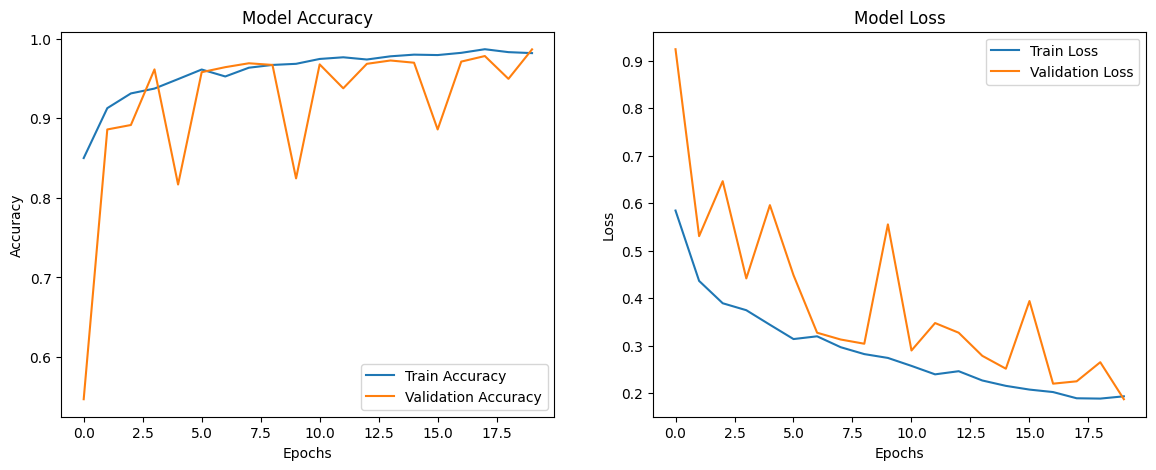

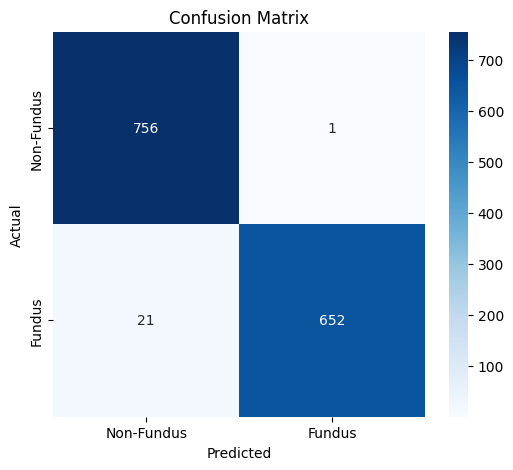

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.show()

# Call the function to plot
plot_training_history(history)


In [3]:
import os
import hashlib
import numpy as np
from PIL import Image, ImageEnhance
import random

def detect_duplicates(folder):
    """Detects duplicate images and returns a dictionary mapping duplicates to their class."""
    duplicates_per_class = {}
    
    for cls in os.listdir(folder):  
        class_path = os.path.join(folder, cls)
        hashes = {}  # Reset hash storage per class
        duplicates_per_class[cls] = []

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            try:
                with Image.open(filepath) as img:
                    img_hash = hashlib.md5(img.tobytes()).hexdigest()

                    if img_hash in hashes:
                        print(f"⚠️ Duplicate in {cls}: {filename} (Same as {hashes[img_hash]})")
                        duplicates_per_class[cls].append(filepath)  # Store duplicate filepath
                    else:
                        hashes[img_hash] = filename  
            except Exception as e:
                print(f"Skipping {filename}: {e}")

    print("\n📊 Duplicate Image Count Per Class:", {cls: len(duplicates) for cls, duplicates in duplicates_per_class.items()})
    return duplicates_per_class

def augment_image(image):
    """Applies random augmentations to an image to make it unique."""
    # Random Rotation
    image = image.rotate(random.choice([0, 90, 180, 270]))
    
    # Random Flip
    if random.choice([True, False]):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if random.choice([True, False]):
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Random Brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(random.uniform(0.7, 1.3))  

    return image

def augment_duplicates(folder, duplicates_per_class):
    """Applies augmentation to detected duplicate images and replaces them."""
    for cls, duplicate_files in duplicates_per_class.items():
        for filepath in duplicate_files:
            try:
                with Image.open(filepath) as img:
                    augmented_img = augment_image(img)
                    new_filepath = filepath.replace(".png", "_aug.png").replace(".jpg", "_aug.jpg")  # New filename
                    augmented_img.save(new_filepath)
                    print(f"✅ Augmented and saved: {new_filepath}")
            except Exception as e:
                print(f"Error augmenting {filepath}: {e}")

# Run Duplicate Handling
dataset_path = "D:/Datasets_Retina"
duplicates_per_class = detect_duplicates(dataset_path)
augment_duplicates(dataset_path, duplicates_per_class)


⚠️ Duplicate in Fundus: 19e350c7c83c.png (Same as 19722bff5a09.png)
⚠️ Duplicate in Fundus: 1e143fa3de57.png (Same as 144b01e7b993.png)
⚠️ Duplicate in Fundus: 1f07dae3cadb.png (Same as 012a242ac6ff.png)
⚠️ Duplicate in Fundus: 2b21d293fdf2.png (Same as 2a3a1ed1c285.png)
⚠️ Duplicate in Fundus: 2c2aa057afc5.png (Same as 135575dc57c9.png)
⚠️ Duplicate in Fundus: 3044022c6969.png (Same as 04ac765f91a1.png)
⚠️ Duplicate in Fundus: 33105f9b3a04.png (Same as 111898ab463d.png)
⚠️ Duplicate in Fundus: 35aa7f5c2ec0.png (Same as 1c4d87baaffc.png)
⚠️ Duplicate in Fundus: 36ec36c301c1.png (Same as 26e231747848.png)
⚠️ Duplicate in Fundus: 38fe9f854046.png (Same as 1dfbede13143.png)
⚠️ Duplicate in Fundus: 3c53198519f7.png (Same as 1c5e6cdc7ee1.png)
⚠️ Duplicate in Fundus: 3ca637fddd56.png (Same as 3b4a5fcbe5e0.png)
⚠️ Duplicate in Fundus: 3e86335bc2fd.png (Same as 0c7e82daf5a0.png)
⚠️ Duplicate in Fundus: 435d900fa7b2.png (Same as 1006345f70b7.png)
⚠️ Duplicate in Fundus: 4a44cc840ebe.png (Same a

In [ ]:
import os
import shutil
import uuid
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

def detect_duplicates(folder):
    """Detect duplicate images in dataset"""
    seen = {}
    duplicates = {}
    for cls in os.listdir(folder):
        class_path = os.path.join(folder, cls)
        if not os.path.isdir(class_path):
            continue
        duplicates[cls] = []
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img_hash = hash(img.tobytes())
                if img_hash in seen:
                    duplicates[cls].append(img_path)
                else:
                    seen[img_hash] = img_path
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return duplicates

def augment_image(image):
    return image.transpose(Image.FLIP_LEFT_RIGHT)

def augment_duplicates(folder, duplicates_per_class, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for cls, duplicate_files in duplicates_per_class.items():
        class_output_path = os.path.join(output_folder, cls)
        os.makedirs(class_output_path, exist_ok=True)
        for filepath in duplicate_files:
            try:
                with Image.open(filepath) as img:
                    augmented_img = augment_image(img)
                    new_filename = f"{os.path.splitext(os.path.basename(filepath))[0]}_{uuid.uuid4().hex[:6]}.png"
                    new_filepath = os.path.join(class_output_path, new_filename)
                    augmented_img.save(new_filepath)
            except Exception as e:
                print(f"Error augmenting {filepath}: {e}")

def split_data(source_dir, output_dir, train_ratio=0.7, val_ratio=0.2):
    test_ratio = 1 - (train_ratio + val_ratio)
    for cls in os.listdir(source_dir):
        class_path = os.path.join(source_dir, cls)
        if not os.path.isdir(class_path):
            continue
        images = os.listdir(class_path)
        train, temp = train_test_split(images, test_size=(1 - train_ratio), stratify=[cls]*len(images), random_state=42)
        val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), stratify=[cls]*len(temp), random_state=42)
        for subset, subset_images in zip(["train", "val", "test"], [train, val, test]):
            subset_path = os.path.join(output_dir, subset, cls)
            os.makedirs(subset_path, exist_ok=True)
            for img_name in subset_images:
                shutil.copy(os.path.join(class_path, img_name), os.path.join(subset_path, img_name))

# Define Paths
dataset_path = "D:/Datasets_Retina"
augmented_dataset_path = "D:/Datasets_Retina_Augmented"
combined_dataset_path = "D:/Datasets_Combined"
final_dataset_path = "D:/Datasets_Final"

duplicates_per_class = detect_duplicates(dataset_path)
augment_duplicates(dataset_path, duplicates_per_class, augmented_dataset_path)

shutil.copytree(dataset_path, combined_dataset_path, dirs_exist_ok=True)
shutil.copytree(augmented_dataset_path, combined_dataset_path, dirs_exist_ok=True)

split_data(combined_dataset_path, final_dataset_path)

# Image Processing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.7, 1.3]
)

train_generator = data_gen.flow_from_directory(os.path.join(final_dataset_path, "train"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
val_generator = data_gen.flow_from_directory(os.path.join(final_dataset_path, "val"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)
test_generator = data_gen.flow_from_directory(os.path.join(final_dataset_path, "test"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

# CNN Model with Regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Fundus", "Fundus"]))

Found 7066 images belonging to 2 classes.
Found 2787 images belonging to 2 classes.
Found 1459 images belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9407 - loss: 6.4233 - val_accuracy: 0.5719 - val_loss: 35.5293
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.9692 - loss: 3.1142 - val_accuracy: 0.8005 - val_loss: 12.1331
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9659 - loss: 2.2120

KeyboardInterrupt: 

In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fundus', 'Fundus'], yticklabels=['Non-Fundus', 'Fundus'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()